# Waterfilling Levels

In [5]:
import sys
import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import cvxpy as cp

# importlib.reload(food_bank_functions)

In [6]:
def generate_cvxpy_solve(num_types, num_resources):
    x = cp.Variable(shape=(num_types,num_resources))

    sizes = cp.Parameter(num_types, nonneg=True)
    weights = cp.Parameter((num_types, num_resources), nonneg=True)
    budget = cp.Parameter(num_resources, nonneg=True)


    objective = cp.Maximize(cp.log(cp.sum(cp.multiply(x, weights), axis=1)) @ sizes)


    constraints = []
    constraints += [0 <= x]
    for i in range(num_resources):
        constraints += [x[:, i] @ sizes <= budget[i]]
    constraints += [x @ sizes <= budget]

    prob = cp.Problem(objective, constraints)
    
    def solver(true_sizes, true_weights, true_budget):
        sizes.value = true_sizes
        weights.value = true_weights
        budget.value = true_budget
        
        prob.solve()
        
        return prob.value, x.value
    
    return prob, solver

### Test

In [7]:
prob, solver = generate_cvxpy_solve(2, 2)

solver(np.asarray([1., 1.]), np.asarray([[1,1],[1,1]]), np.asarray([1,1]))

(1.0641477147538018e-09,
 array([[0.50000001, 0.49999999],
        [0.49999999, 0.50000001]]))

### Plot Sensitivity

Calculating difference in allocations for: 0.5
Sizes: ([1.0, 1.0], [0.5, 0.5], [1.5, 1.5])
Solutions: (array([[1., 1.],
       [1., 1.]]), array([[2., 2.],
       [2., 2.]]), array([[0.66667814, 0.66665519],
       [0.66665519, 0.66667814]]))
Objective Values: (1.3862943608168272, 1.3862943595465607, 0.8630462191813028)
Testing Budget Constraint: 
[ True  True]
Testing Monotonicity:
[[ True  True]
 [ True  True]]
[[ True  True]
 [ True  True]]
[0.5] [1.] [0.33334481]


c:\users\seanr\anaconda3\envs\food-bank\lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:163: UserWarning: You are solving a parameterized problem that is not DPP. Because the problem is not DPP, subsequent solves will not be faster than the first one. For more information, see the documentation on Discplined Parametrized Programming, at
	https://www.cvxpy.org/tutorial/advanced/index.html#disciplined-parametrized-programming
  warnings.warn(dpp_error_msg)


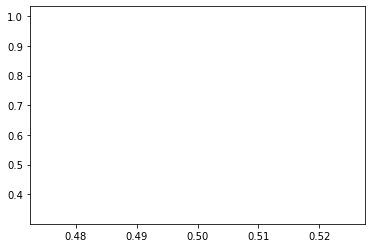

In [11]:
eps = 0.05

delta_list = [.5]
y1 = np.zeros(len(delta_list))
y2 = np.zeros(len(delta_list))

prob, solver = generate_cvxpy_solve(2, 2)
true_weights = np.asarray([[1., 1.],[1., 1.]])
true_budget = [2., 2.]


index = 0
for delta in delta_list:
    print('Calculating difference in allocations for: ' + str(delta))
    sizes_1 = [1., 1.]
    sizes_2 = [1-delta, 1-delta]
    sizes_3 = [1+delta, 1+delta]
    
    print('Sizes: ' + str((sizes_1, sizes_2, sizes_3)))
          
    v1, x_1 = solver(sizes_1, true_weights, true_budget)
    v2, x_2 = solver(sizes_2, true_weights, true_budget)
    v3, x_3 = solver(sizes_3, true_weights, true_budget)
    
    print('Solutions: ' + str((x_1, x_2, x_3)))
    print('Objective Values: ' + str((v1, v2, v3)))
    
    print('Testing Budget Constraint: ')
    print(sizes_1 @ x_1 <= true_budget)
    
    print('Testing Monotonicity:')
    print(x_1 <= x_2)
    print(x_1 >= x_3)
    y1[index] = np.max(np.abs(x_1 - x_2))
    y2[index] = np.max(np.abs(x_1 - x_3))
    index += 1
    
print(delta_list, y1, y2)
plt.plot(delta_list, y1)
plt.plot(delta_list, y2)